In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import gymnasium as gym
import os
import qiskit
from gymnasium import spaces
from stable_baselines3 import PPO, A2C, DQN, TD3, SAC
from stable_baselines3.common.env_util import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecNormalize

from qiskit.quantum_info import random_density_matrix, random_statevector, DensityMatrix
from adaptive_qst.plotting import PlotOneQubit
from adaptive_qst.max_info import Posterior, HiddenState
#from adaptive_qst.rl_qst import AQSTEnv
import matplotlib.pyplot as plt
from numpy import pi
from qiskit.quantum_info import state_fidelity

from numpy import sqrt
from numpy.linalg import cholesky

## Custom Environment

In [4]:
from scipy.stats import boxcox

class AQSTEnv(gym.Env):
    
    def __init__(self, n_particles = 30, n_measurements = 1000, hidden_state = None, reward_start = 100):
        super(AQSTEnv, self).__init__()
        
        self.n_particles = n_particles
        self.n_measurements = n_measurements
        self.posterior = Posterior(self.n_particles)
        self.change_state = (hidden_state is None)
        
        self.hidden_state = hidden_state
        
        if self.change_state:
            self.hidden_state = HiddenState()
    
        self.step_num = 0
        self.reward_start = reward_start

        self.observation_space = gym.spaces.Box(low = -np.inf, high = np.inf, shape = (4 * self.n_particles,))  ##3 variables per density matrix, 1 variable for weight
        
        self.action_space = gym.spaces.Box(low= -1, high = 1, shape = (2,))  ##Orientation of measurement

    def step(self, action):
        
        config = (action + 1) * pi / 2
        result = self.hidden_state.measure_along_axis(config)
        self.posterior.update(config, result)
        fidelity = state_fidelity(self.hidden_state.hidden_state, self.posterior.get_best_guess())
        
        reward = -np.log(1 - fidelity) / np.log(self.step_num + 8)

        self.step_num += 1
        truncated = (self.step_num >= self.n_measurements)
        terminated = False

        return (self.get_observations(), 
                reward, 
                terminated, 
                truncated, 
                {})

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)

        self.posterior = Posterior(self.n_particles)
        if not self.change_state:
            self.hidden_state = HiddenState()
            
        self.step_num = 0
        
        return self.get_observations(), {}
    
    #Package complex density matrix and weights into observation vector (x, y, z positions)
    def get_observations(self):
        observations = np.zeros(4 * self.n_particles)
        perm = np.random.permutation(self.n_particles)
        particle_states = self.posterior.particle_states[perm]
        particle_weights = self.posterior.particle_weights[perm]
        
        observations[:self.n_particles] = 2 * np.real(particle_states[:, 0, 0]) - 1
        observations[self.n_particles : 2 * self.n_particles] = 2 * np.real(particle_states[:, 0, 1])
        observations[2 * self.n_particles : 3 * self.n_particles] = 2 * np.imag(particle_states[:, 0, 1])
        observations[3 * self.n_particles:] = (boxcox(particle_weights, 0.2) + 5)/6
        

        observations[:3 * self.n_particles] = observations[:3 * self.n_particles] / 2 + 0.5

        return observations.astype(np.float32)

In [21]:
env = AQSTEnv()
check_env(env, warn=True)

## Comparison between models

In [4]:
RL = 0
INFO = 1
RANDOM = 2
CONSTANT = 3

def observe(n_steps, model_type, model = None, hidden_state = None, n_particles = 30):
    env = AQSTEnv(n_measurements = n_steps + 10, hidden_state = hidden_state, n_particles = n_particles)
    
    obs, _ = env.reset()
    actions = []
    rewards = []
    for i in range(n_steps):
        episode_rewards = []
        done = False
        
        if model_type == RL:
            action, _states = model.predict(obs, deterministic = True)
            
        elif model_type == INFO:
            action = (env.posterior.get_best_config() * 2 / pi) - 1
            
        elif model_type == RANDOM:
            action = 2 * np.random.rand(2) - 1
        
        elif model_type == CONSTANT:
            action = np.array([0, 0])
        else:
            print("Invalid model type!")
            return
        

        obs, reward, truncated, terminated, _info = env.step(action)
        actions.append(action)
        rewards.append(reward)

    return actions, rewards

def get_avg(n_tests, n_steps, model_type, model = None, hidden_state = None, n_particles = 30):
    sums = np.zeros(n_steps)
    for i in range(n_tests):
        print(i)
        sums += observe(n_steps, model_type, model, hidden_state, n_particles)[1]
        
    return sums / n_tests

# info_avg = get_avg(n_tests = 32, n_steps = 500, model_type = INFO)
# random_avg = get_avg(n_tests = 32, n_steps = 500, model_type = RANDOM)
# constant_avg = get_avg(n_tests = 32, n_steps = 500, model_type = CONSTANT)

## Featurization
Want to have approximately normally distributed features... is this what we observe?

In [ ]:
n_steps = 100
n_tests = 100
n_particles = 30

obs_arr = np.zeros((n_tests, n_steps, n_particles * 4))
rew_arr = np.zeros((n_tests, n_steps - 1))


for i in range(n_tests):
    print(f"running {i}")
    env = AQSTEnv(n_measurements = n_steps + 10, n_particles = n_particles)
    
    obs, _ = env.reset()
    obs_arr[i, 0] = obs
    
    for j in range(1, n_steps):
        action = 2 * np.random.rand(2) - 1
        obs, reward, truncated, terminated, _info = env.step(action)
            
        obs_arr[i, j] = obs
        rew_arr[i, j - 1] = reward

In [24]:
obs_arr.shape
rew_arr.shape

(100, 99)

(array([4709., 2890., 2657., 2611., 2548., 2543., 2469., 2408., 2476.,
        2451., 2467., 2446., 2361., 2482., 2606., 2617., 2671., 2695.,
        2683., 2828., 2978., 2936., 3077., 3022., 3170., 3201., 3264.,
        3305., 3358., 3363., 3423., 3389., 3576., 3769., 3687., 3753.,
        3737., 3796., 3988., 4318., 4238., 4280., 4406., 4518., 4442.,
        4568., 4712., 4648., 4700., 4823., 4869., 4862., 5090., 5117.,
        5291., 5240., 5400., 8243., 5329., 5428., 5306., 5336., 5327.,
        5131., 4992., 4665., 4463., 4423., 4184., 3835., 3519., 3102.,
        2730., 2488., 2038., 1818., 1613., 1392., 1255., 1171., 1003.,
        1025.,  867.,  746.,  721.,  628.,  551.,  478.,  356.,  331.,
         263.,  264.,  230.,  213.,  183.,  140.,  110.,   85.,   66.,
          20.]),
 array([7.94728597e-08, 7.38938868e-03, 1.47786979e-02, 2.21680071e-02,
        2.95573163e-02, 3.69466255e-02, 4.43359347e-02, 5.17252439e-02,
        5.91145531e-02, 6.65038623e-02, 7.38931715e-02, 8.

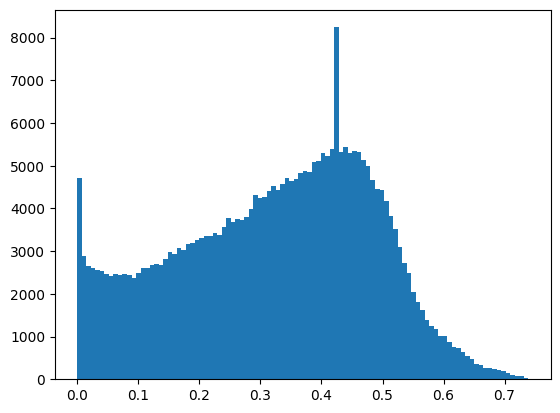

In [49]:
plt.hist((obs_arr[:, :, 3 * n_particles : 4 * n_particles].flatten() + 5)/6, bins = 100)

## Run Model

In [2]:
model_save_dir = "models/rl_qst"
tb_log_dir = "tb_logs/rl_qst/1_qubit"

In [64]:
run_name = "A2C_vecnormalize_long"
model_save_path = f"{model_save_dir}/{run_name}"

batch_size = 32
n_measurements = 1000
n_train_episodes = 100
eval_episode_freq = 1
n_eval_episodes = 20

train_env = DummyVecEnv([lambda: Monitor(AQSTEnv(n_measurements = n_measurements)) for _ in range(batch_size)])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=False)

eval_env = DummyVecEnv([lambda: Monitor(AQSTEnv(n_measurements = n_measurements))])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)

eval_callback = EvalCallback(eval_env, best_model_save_path=model_save_path,
                             deterministic=True, render=False, n_eval_episodes = n_eval_episodes,
                             eval_freq = eval_episode_freq * n_measurements)


model = A2C("MlpPolicy", train_env, tensorboard_log = tb_log_dir, n_steps = 5)
model.learn(batch_size * n_measurements * n_train_episodes, tb_log_name=run_name, callback = eval_callback)

Eval num_timesteps=32000, episode_reward=641.17 +/- 136.84
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=64000, episode_reward=624.93 +/- 132.52
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=514.28 +/- 85.40
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=128000, episode_reward=565.55 +/- 113.29
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=160000, episode_reward=652.72 +/- 114.18
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=192000, episode_reward=592.79 +/- 153.01
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=224000, episode_reward=582.27 +/- 90.88
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=256000, episode_reward=631.98 +/- 99.55
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=288000, episode_reward=617.11 +/- 123.95
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=320000, episode_reward=720.13 +/- 159.36
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_t

Eval num_timesteps=2784000, episode_reward=488.09 +/- 140.81
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=2816000, episode_reward=503.92 +/- 130.76
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=2848000, episode_reward=625.71 +/- 143.27
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=2880000, episode_reward=523.00 +/- 102.17
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=2912000, episode_reward=463.10 +/- 137.72
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=2944000, episode_reward=420.16 +/- 102.21
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=2976000, episode_reward=500.25 +/- 150.64
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=3008000, episode_reward=525.44 +/- 256.44
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=3040000, episode_reward=535.42 +/- 180.67
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=3072000, episode_reward=552.74 +/- 178.78
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=3104000, episode_reward=526.47 +/- 200.06

In [66]:
eval_env = DummyVecEnv([lambda: Monitor(AQSTEnv(n_measurements = n_measurements))])
eval_env = VecNormalize(eval_env, norm_obs = True, norm_reward=False)

best_model = A2C.load(f"{model_save_path}/best_model", eval_env)
    
#best_model.set_env(eval_env)
obs = eval_env.reset()

actions = []
rews = []

for _ in range(1000):
    action, _states = model.predict(obs, deterministic = True)
    obs, rewards, dones, info = eval_env.step(action)
    
    actions.append(action)
    rews.append(rewards)
    
#print(actions)
for action in actions: print(action)

[[-0.6042969 -1.       ]]
[[-1. -1.]]
[[1. 1.]]
[[-1. -1.]]
[[-1. -1.]]
[[1. 1.]]
[[-1.         -0.93246776]]
[[-1. -1.]]
[[1. 1.]]
[[0.75051045 0.64447397]]
[[-1. -1.]]
[[-1. -1.]]
[[-1. -1.]]
[[0.2307939  0.84057873]]
[[-1. -1.]]
[[-0.49232233 -0.5150554 ]]
[[-0.04388712  0.5537459 ]]
[[1. 1.]]
[[-0.43021408 -0.8223274 ]]
[[1.         0.50666976]]
[[-1. -1.]]
[[-0.97393996 -1.        ]]
[[0.6373162 0.5376432]]
[[-1. -1.]]
[[-0.6493323   0.18262458]]
[[-1. -1.]]
[[ 0.1707724  -0.07568804]]
[[ 0.4126765  -0.73090893]]
[[-1. -1.]]
[[-1. -1.]]
[[-0.9102757 -1.       ]]
[[1.         0.91880345]]
[[0.29328516 1.        ]]
[[0.6365971 1.       ]]
[[-0.5465915 -1.       ]]
[[-1. -1.]]
[[-0.33306545 -0.18299598]]
[[-0.4542905 -0.9602618]]
[[-0.9708368 -0.3211619]]
[[-1. -1.]]
[[-0.17986542 -0.15023254]]
[[-1. -1.]]
[[-0.42948917 -1.        ]]
[[1. 1.]]
[[1. 1.]]
[[0.35165393 1.        ]]
[[-1. -1.]]
[[0.15954077 0.67054087]]
[[1. 1.]]
[[-1. -1.]]
[[-1. -1.]]
[[-1. -1.]]
[[0.13334253 1.       

In [ ]:
run_name = "A2C_fix_state"
model_save_path = f"{model_save_dir}/{run_name}"


particle_states = Posterior(n_particles).particle_states
def make_env():
    return AQSTEnv(particle_states, n_measurements = 100)

train_env = DummyVecEnv([lambda: Monitor(make_env()) for _ in range(32)])

eval_env = AQSTEnv(particle_states, n_measurements = 100)
eval_callback = EvalCallback(eval_env, best_model_save_path=model_save_path,
                             eval_freq=32_000, deterministic=True, render=False, n_eval_episodes = 20)


model = A2C("MlpPolicy", train_env, tensorboard_log = tb_log_dir)
model.learn(512_000, callback=eval_callback, tb_log_name=run_name)

## Block experiment!

In [61]:
block_size = 50
n_configs = 10
n_tests = 32

def run_block(n_configs, block_size, hidden_state, adaptive):
    infidelity_arr_bayes = []
    posterior = Posterior()

    for i in range(n_configs):

        if not adaptive:
                config = pi * np.random.rand(2)
        
        else:
            config = posterior.get_best_config()
    
        for j in range(block_size):
            
            res = hidden_state.measure_along_axis(config)
            posterior.update(config, res)

        infidelity_arr_bayes.append(1 - state_fidelity(posterior.get_best_guess(), hidden_state.hidden_state))
        
    return infidelity_arr_bayes


infidelities = np.zeros((n_tests, 2, n_configs))

for i in range(n_tests):
    print(f"Running {i}")
    hidden_state = HiddenState(random_density_matrix(2).data)
    
    infidelities[i, 0] = run_block(n_configs, block_size, hidden_state, adaptive = True)
    infidelities[i, 1] = run_block(n_configs, block_size, hidden_state, adaptive = False)
    

Running 0
Running 1
Running 2
Running 3
Running 4
Running 5
Running 6
Running 7
Running 8
Running 9
Running 10
Running 11
Running 12
Running 13
Running 14
Running 15
Running 16
Running 17
Running 18
Running 19
Running 20
Running 21
Running 22
Running 23
Running 24
Running 25
Running 26
Running 27
Running 28
Running 29
Running 30
Running 31


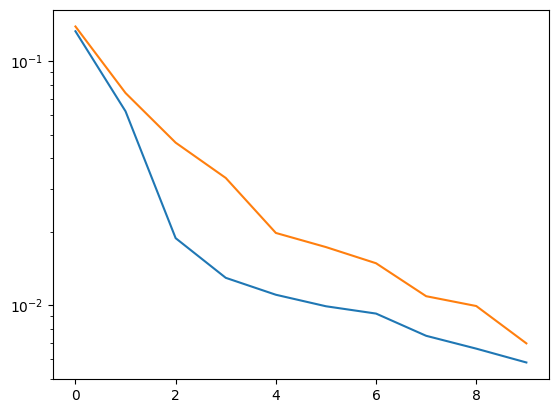

In [62]:
avgs = np.mean(infidelities, axis = 0)
x_arr = np.arange(n_configs)
plt.plot(x_arr, avgs[0])
plt.plot(x_arr, avgs[1])

plt.yscale('log')
#plt.xscale('log')

## Distribution size

In [56]:
def run_size(hidden_state, adaptive, n_steps):
    size_arr = []
    posterior = Posterior()

    for i in range(n_steps):

        if not adaptive:
                config = pi * np.random.rand(2)
        
        else:
            config = posterior.get_best_config()
            
        res = hidden_state.measure_along_axis(config)
        posterior.update(config, res)
        
        size = -np.sum(posterior.particle_weights * np.log(posterior.particle_weights), axis = -1)
        
        size_arr.append(size)
        
    return size_arr

sizes = run_size(HiddenState(random_density_matrix(2).data), adaptive = True, n_steps = 500)
sizes_2 = run_size(HiddenState(random_density_matrix(2).data), adaptive = False, n_steps = 500)

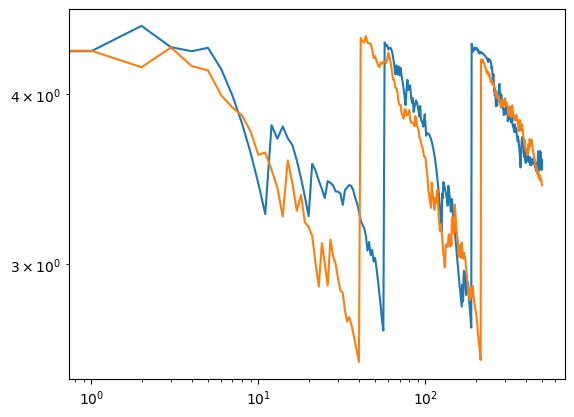

In [57]:
plt.plot(np.arange(500), sizes)
plt.plot(np.arange(500), sizes_2)

plt.yscale('log')
plt.xscale('log')